**News Topic Classifier using BERT (bert-base-uncased)**
Single-file script with two modes:
  1) Train: python news_topic_classifier_bert.py --mode train
  2) Serve (Streamlit): streamlit run news_topic_classifier_bert.py -- --mode app

**Features:**
- Loads AG News from Hugging Face Datasets
- Tokenizes using bert-base-uncased
- Fine-tunes using Hugging Face Trainer API
- Computes Accuracy and Macro F1
- Saves best model
- Lightweight Streamlit app for live inference

This solution intentionally uses the Hugging Face Trainer API and a Streamlit app for deployment
— if your previous approach used a custom PyTorch loop or Gradio, this will be a different method.

**Requirements:**
transformers, datasets, sklearn, torch, streamlit
**Install with:**
  pip install transformers datasets scikit-learn torch streamlit


In [2]:
!pip install -q transformers datasets evaluate gradio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.1 MB/s eta 0:00:00


In [3]:
import numpy as np
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)
import evaluate
import torch


In [4]:
# AG News: 120k train, 7.6k test, 4 categories (World, Sports, Business, Sci/Tech)
dataset = load_dataset("ag_news")

# Make a validation split from training set (10%)
dataset = dataset["train"].train_test_split(test_size=0.1, seed=42)
train_ds = dataset["train"]
val_ds = dataset["test"]
test_ds = load_dataset("ag_news", split="test")

print(train_ds[0])  # show one example


{'text': 'Despair and Anger in Small Russian Town After Siege  BESLAN, Russia (Reuters) - The killing of more than 320  children, parents and teachers during the bloody end to a  53-hour school siege left barely a family untouched in the  small Russian town of Beslan.', 'label': 0}


In [5]:
MODEL_NAME = "bert-base-uncased"
MAX_LEN = 128

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def preprocess(examples):
    return tokenizer(examples["text"], truncation=True, max_length=MAX_LEN)

train_ds = train_ds.map(preprocess, batched=True, remove_columns=["text"])
val_ds = val_ds.map(preprocess, batched=True, remove_columns=["text"])
test_ds = test_ds.map(preprocess, batched=True, remove_columns=["text"])


Map:   0%|          | 0/108000 [00:00<?, ? examples/s]

Map:   0%|          | 0/12000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [6]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=4)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy.compute(predictions=preds, references=labels)["accuracy"]
    f1_macro = f1.compute(predictions=preds, references=labels, average="macro")["f1"]
    return {"accuracy": acc, "f1_macro": f1_macro}


/tmp/ipython-input-920218342.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=label_names, order=["World","Sports","Business","Sci/Tech"], palette="viridis")


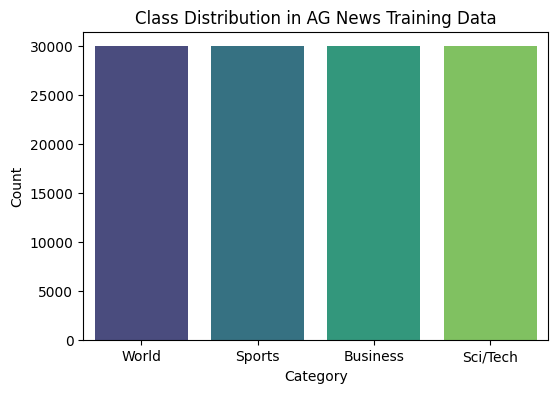

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from datasets import load_dataset

# Load AG News
dataset = load_dataset("ag_news")

# Training data labels
train_labels = [example['label'] for example in dataset['train']]

# Map labels
id2label = {0: "World", 1: "Sports", 2: "Business", 3: "Sci/Tech"}
label_names = [id2label[l] for l in train_labels]

# Plot
plt.figure(figsize=(6,4))
sns.countplot(x=label_names, order=["World","Sports","Business","Sci/Tech"], palette="viridis")
plt.title("Class Distribution in AG News Training Data")
plt.xlabel("Category")
plt.ylabel("Count")
plt.show()


In [9]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",  # Changed from evaluation_strategy
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    logging_dir="./logs",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipython-input-529645731.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [12]:
# Use only a subset of training data (e.g., 2000 samples)
small_train_dataset = train_ds.shuffle(seed=42).select(range(2000))
small_eval_dataset = val_ds.shuffle(seed=42).select(range(500))

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()

/tmp/ipython-input-445487410.py:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,No log,0.228385,0.926000,0.922751
2,No log,0.284666,0.920000,0.916727
3,No log,0.295429,0.924000,0.920943


TrainOutput(global_step=375, training_loss=0.12049714152018229, metrics={'train_runtime': 158.0686, 'train_samples_per_second': 37.958, 'train_steps_per_second': 2.372, 'total_flos': 288185780518272.0, 'train_loss': 0.12049714152018229, 'epoch': 3.0})

In [13]:
results = trainer.evaluate(test_ds)
print("Test Results:", results)


Test Results: {'eval_loss': 0.23096925020217896, 'eval_accuracy': 0.9272368421052631, 'eval_f1_macro': 0.9271195376118765, 'eval_runtime': 11.5512, 'eval_samples_per_second': 657.942, 'eval_steps_per_second': 41.121, 'epoch': 3.0}


In [14]:
trainer.save_model("./saved_model")
tokenizer.save_pretrained("./saved_model")


('./saved_model/tokenizer_config.json',
 './saved_model/special_tokens_map.json',
 './saved_model/vocab.txt',
 './saved_model/added_tokens.json',
 './saved_model/tokenizer.json')

In [18]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import gradio as gr

# Load fine-tuned model and tokenizer
model_path = "./saved_model"   # <-- replace with your checkpoint folder
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

# Map labels
id2label = {0: "World", 1: "Sports", 2: "Business", 3: "Sci/Tech"}

def classify(text):
    try:
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
        with torch.no_grad():
            outputs = model(**inputs)
        logits = outputs.logits
        pred_id = torch.argmax(logits, dim=1).item()
        return id2label[pred_id]
    except Exception as e:
        return f"Error: {str(e)}"

# Gradio Interface
iface = gr.Interface(
    fn=classify,
    inputs=gr.Textbox(lines=2, placeholder="Enter news headline here..."),
    outputs="text",
    title="AG News Topic Classifier"
)

iface.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://a734aa72252b5cb5ae.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
